In [2]:
!pip install devex_sdk

from devex_sdk import setup_runner
setup_runner()

from devex_sdk import Spark_Data_Connector, Nested_Json_Connector
from pyspark.sql.functions import col, count
import pyspark.sql.functions as F

b"Get:1 http://security.debian.org/debian-security buster/updates InRelease [34.8 kB]\nHit:2 http://deb.debian.org/debian buster InRelease\nHit:3 http://deb.debian.org/debian buster-updates InRelease\nGet:4 http://security.debian.org/debian-security buster/updates/main amd64 Packages [523 kB]\nFetched 558 kB in 0s (1987 kB/s)\nReading package lists...\nBuilding dependency tree...\nReading state information...\n64 packages can be upgraded. Run 'apt list --upgradable' to see them.\nReading package lists...\nBuilding dependency tree...\nReading state information...\nsudo is already the newest version (1.8.27-1+deb10u5).\n0 upgraded, 0 newly installed, 0 to remove and 64 not upgraded.\nReading package lists...\nBuilding dependency tree...\nReading state information...\ndefault-jre is already the newest version (2:1.11-71).\n0 upgraded, 0 newly installed, 0 to remove and 64 not upgraded.\nReading package lists...\nBuilding dependency tree...\nReading state information...\npython3 is already

In [3]:
from datetime import datetime
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import collect_list
from datetime import datetime
from matplotlib.dates import DateFormatter
from pyspark.sql.functions import explode,lit
from pyspark.sql.functions import to_timestamp

In [4]:
json_object_path = 'prometheus-tsdb-dump/df72.json'
obj = Nested_Json_Connector(json_object_path)
err, df1 = obj.read_nested_json()

/opt/conda/lib/python3.7/site-packages/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)


Nested_Json_Connector initialized with the following s3_file_path:prometheus-tsdb-dump/df72.json


In [5]:
df = df1

In [6]:
from pyspark.sql import functions
from pyspark.sql.functions import expr,from_unixtime
df_date = df.withColumn("date_col",  expr("transform(timestamps, x -> from_unixtime(x / 1000))"))

### container_memory_max_usage_bytes

In [7]:
df_filter1 = df_date.filter(col("metric_pod").startswith('open5gs-amf-6d85b8c465-fzg2t')).select("metric_pod",'date_col','metric___name__','values','metric_id').filter((col('metric___name__')=='container_memory_max_usage_bytes'))
# df_filter1.show(df_filter1.count(),truncate=False)

In [12]:
pod11 = df_date.filter(col("metric_pod").startswith('open5gs-amf-6d85b8c465-fzg2t')).select("metric_pod",'date_col','metric___name__','values','metric_id').filter((col('metric___name__')=='container_memory_max_usage_bytes'))
# pod11.show(df_date.count(),truncate=False)
pod12 = df_date.filter(col("metric_pod").startswith('open5gs-amf-54cc5d554b-pjq4v')).select("metric_pod",'date_col','metric___name__','values','metric_id').filter((col('metric___name__')=='container_memory_max_usage_bytes'))
# pod12.show(df_date.count(),truncate=False)

In [9]:
def get_pod(pod,valuename):

    x_values = pod.select("date_col").rdd.flatMap(lambda x: x).collect()
    y_values = pod.select("values").rdd.flatMap(lambda x: x).collect()
    result_dict = {}
    for x_list, y_list in zip(x_values, y_values):
        for x, y in zip(x_list, y_list):
            if x in result_dict:
                result_dict[x].append(float(y))
            else:
                result_dict[x] = [float(y)]
    return result_dict


In [10]:
pod11_dict = get_pod(pod11,'container_memory_max_usage_bytes_value')
pod12_dict = get_pod(pod12,'container_memory_max_usage_bytes_value')

In [11]:
pod11_dict

{'2023-06-06 14:57:59': [7561216.0],
 '2023-06-06 14:58:26': [7565312.0, 53219328.0],
 '2023-06-06 14:59:08': [7577600.0],
 '2023-06-06 14:59:28': [7577600.0],
 '2023-06-06 15:00:03': [7577600.0],
 '2023-06-06 15:00:39': [7577600.0],
 '2023-06-06 15:00:58': [7577600.0, 53219328.0],
 '2023-06-06 15:01:31': [7577600.0],
 '2023-06-06 15:02:05': [7585792.0],
 '2023-06-06 15:02:36': [7589888.0],
 '2023-06-06 15:03:07': [7905280.0],
 '2023-06-06 15:03:35': [7905280.0],
 '2023-06-06 15:04:09': [7909376.0],
 '2023-06-06 15:04:32': [7917568.0],
 '2023-06-06 15:04:51': [7921664.0],
 '2023-06-06 15:05:24': [7925760.0],
 '2023-06-06 15:05:57': [7929856.0],
 '2023-06-06 15:06:30': [7933952.0],
 '2023-06-06 15:07:02': [7946240.0],
 '2023-06-06 15:07:30': [7954432.0],
 '2023-06-06 15:07:52': [7962624.0],
 '2023-06-06 15:08:27': [7966720.0],
 '2023-06-06 15:08:53': [7966720.0],
 '2023-06-06 15:09:35': [7983104.0, 4644864.0],
 '2023-06-06 15:09:51': [7987200.0],
 '2023-06-06 15:10:24': [7991296.0],
 '2

In [13]:
def combine(pod):
    value = pod.select(explode(pod11.values).alias('values'),'metric_id')
    time = pod.select(explode(pod11.date_col).alias('date_col'))
    df_merged = value.join(time)
    df_merged = df_merged.withColumn('date_col', to_timestamp('date_col'))
    value = value.toPandas()
    time = time.toPandas()

    values = time.iloc[:, 0].values

    value['date_col'] = values

    spark = SparkSession.builder.getOrCreate()
    combined_df = spark.createDataFrame(value)
    # combined_df = combined_df.toPandas()
    return combined_df

In [14]:
df_pod11 = combine(pod11)
df_pod12 = combine(pod12)

In [15]:
df_pod12.show(700, truncate = False)

+-----------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------+
|values     |metric_id                                                                                                                                                                                        |date_col           |
+-----------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------+
|3174400.0  |/kubepods.slice/kubepods-besteffort.slice/kubepods-besteffort-pod4cc4bf41_eaba_43b4_8fd4_00a41fe807e0.slice/cri-containerd-0e519ee37b5c8f49eeef4aaf8b45276f0e84199c7c1fd120ed48030567c8d2f6.scope|2023-06-06 15:47:27|
|7266304.0  |/kubepods.slice/kubepods-besteffort.slice/kubepods-besteffort-pod4cc4bf41_e

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
def all_container(df, metric):
    df = df.toPandas()
    grouped_df = df.groupby('metric_id')

    fig, ax = plt.subplots()

    for category, group in grouped_df:
        ax.plot(group['date_col'], group['values'], label=category)


    ax.set_xlabel('Date')
    ax.set_ylabel('Values')
    ax.set_title(metric)

    num_ticks = 10

    num_rows = df.shape[0]
    step_size = max(num_rows // num_ticks, 1)
    x_tick_positions = df['date_col'].iloc[::step_size].index
    x_tick_labels = df['date_col'].iloc[::step_size]

    ax.set_xticks(x_tick_positions)
    ax.set_xticklabels(x_tick_labels, rotation=90)

    ax.legend()

    plt.show()


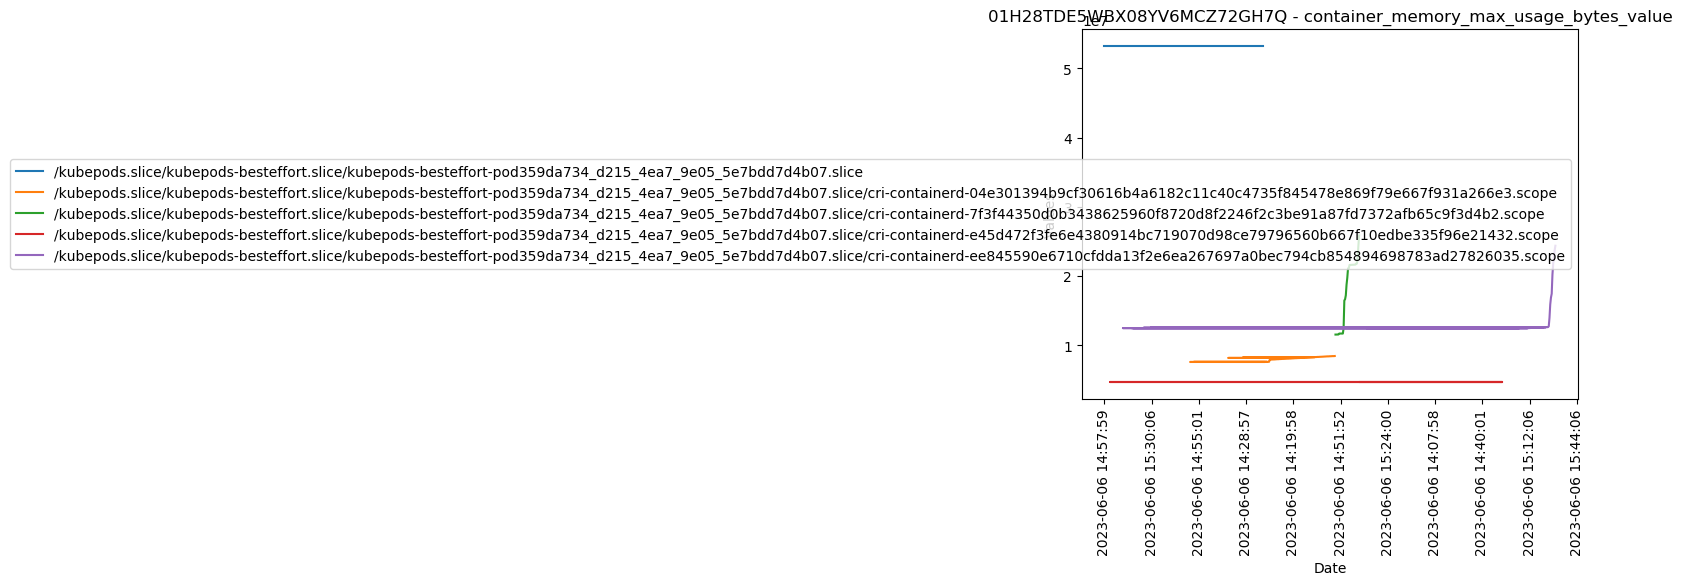

In [17]:
all_container(df_pod11, '01H28TDE5WBX08YV6MCZ72GH7Q - container_memory_max_usage_bytes_value')

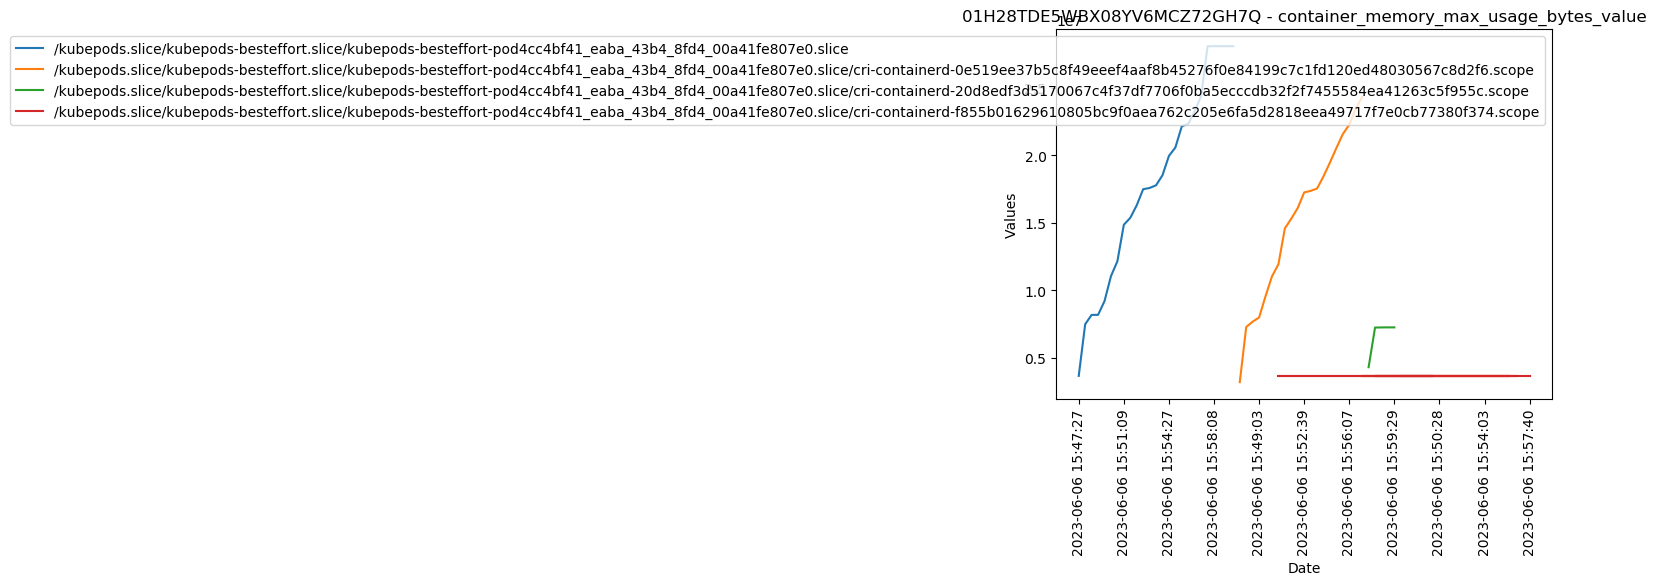

In [18]:
all_container(df_pod12, '01H28TDE5WBX08YV6MCZ72GH7Q - container_memory_max_usage_bytes_value')

In [19]:
def find_duplicates(pod):
    x_values = pod.select("date_col").rdd.flatMap(lambda x: x).collect()
    y_values = pod.select("values").rdd.flatMap(lambda x: x).collect()
    result_dict = {}
    duplicate_timestamps = []
    for x_list, y_list in zip(x_values, y_values):
        for x, y in zip(x_list, y_list):
            if x in result_dict:
                duplicate_timestamps.append(x)
            else:
                result_dict[x] = [float(y)]
    return duplicate_timestamps

In [20]:
# Select 3 containers related to our projects to check duplications
df_pod11 = df_pod11.filter((col("metric_id") == "/kubepods.slice/kubepods-besteffort.slice/kubepods-besteffort-pod359da734_d215_4ea7_9e05_5e7bdd7d4b07.slice/cri-containerd-ee845590e6710cfdda13f2e6ea267697a0bec794cb854894698783ad27826035.scope") | (col("metric_id") == "/kubepods.slice/kubepods-besteffort.slice/kubepods-besteffort-pod359da734_d215_4ea7_9e05_5e7bdd7d4b07.slice/cri-containerd-7f3f44350d0b3438625960f8720d8f2246f2c3be91a87fd7372afb65c9f3d4b2.scope") | (col("metric_id") == "/kubepods.slice/kubepods-besteffort.slice/kubepods-besteffort-pod359da734_d215_4ea7_9e05_5e7bdd7d4b07.slice/cri-containerd-04e301394b9cf30616b4a6182c11c40c4735f845478e869f79e667f931a266e3.scope")).select('values','date_col').withColumnRenamed("values", "container_memory_max_usage_bytes_value")
df_pod11.show()

+--------------------------------------+-------------------+
|container_memory_max_usage_bytes_value|           date_col|
+--------------------------------------+-------------------+
|                             7561216.0|2023-06-06 14:57:59|
|                             7565312.0|2023-06-06 14:58:26|
|                             7577600.0|2023-06-06 14:59:08|
|                             7577600.0|2023-06-06 14:59:28|
|                             7577600.0|2023-06-06 15:00:03|
|                             7577600.0|2023-06-06 15:00:39|
|                             7577600.0|2023-06-06 15:00:58|
|                             7577600.0|2023-06-06 15:01:31|
|                             7585792.0|2023-06-06 15:02:05|
|                             7589888.0|2023-06-06 15:02:36|
|                             7905280.0|2023-06-06 15:03:07|
|                             7905280.0|2023-06-06 15:03:35|
|                             7909376.0|2023-06-06 15:04:09|
|                       

In [21]:
df_pod12 = df_pod12.filter((col("metric_id") == "/kubepods.slice/kubepods-besteffort.slice/kubepods-besteffort-pod4cc4bf41_eaba_43b4_8fd4_00a41fe807e0.slice/cri-containerd-0e519ee37b5c8f49eeef4aaf8b45276f0e84199c7c1fd120ed48030567c8d2f6.scope") | (col("metric_id") == "/kubepods.slice/kubepods-besteffort.slice/kubepods-besteffort-pod4cc4bf41_eaba_43b4_8fd4_00a41fe807e0.slice") | (col("metric_id") == "/kubepods.slice/kubepods-besteffort.slice/kubepods-besteffort-pod4cc4bf41_eaba_43b4_8fd4_00a41fe807e0.slice/cri-containerd-20d8edf3d5170067c4f37df7706f0ba5ecccdb32f2f7455584ea41263c5f955c.scope")).select('values','date_col').withColumnRenamed("values", "container_memory_max_usage_bytes_value")
df_pod12.show()

+--------------------------------------+-------------------+
|container_memory_max_usage_bytes_value|           date_col|
+--------------------------------------+-------------------+
|                             3174400.0|2023-06-06 15:47:27|
|                             7266304.0|2023-06-06 15:48:03|
|                             7659520.0|2023-06-06 15:48:34|
|                             7970816.0|2023-06-06 15:49:09|
|                             9551872.0|2023-06-06 15:49:37|
|                           1.1022336E7|2023-06-06 15:50:09|
|                            1.191936E7|2023-06-06 15:50:28|
|                           1.4577664E7|2023-06-06 15:51:09|
|                           1.5302656E7|2023-06-06 15:51:33|
|                           1.6093184E7|2023-06-06 15:52:06|
|                            1.724416E7|2023-06-06 15:52:35|
|                           1.7358848E7|2023-06-06 15:53:01|
|                           1.7534976E7|2023-06-06 15:53:39|
|                       

In [22]:
def plot(df1,df2, valuename, y_axis_label,n):
    
    # Create a SparkSession
    spark = SparkSession.builder.getOrCreate()

    df1 = df1.withColumnRenamed("date_col", "timestamp")
    df2 = df2.withColumnRenamed("date_col", "timestamp")
    df1_grouped = df1.groupBy("timestamp").agg(collect_list(valuename).alias("values1"))
    df2_grouped = df2.groupBy("timestamp").agg(collect_list(valuename).alias("values2"))

    # Convert timestamp column to a datetime type
    df1_grouped = df1_grouped.withColumn("timestamp", df1_grouped["timestamp"].cast("timestamp"))
    df2_grouped = df2_grouped.withColumn("timestamp", df2_grouped["timestamp"].cast("timestamp"))

    # Collect the data from the DataFrames into the driver node
    data1 = df1_grouped.collect()
    data2 = df2_grouped.collect()

    # Extract the timestamp and value columns
    timestamps1 = [row.timestamp.strftime("%Y-%m-%d %H:%M:%S") for row in data1]
    values1 = [row.values1.pop() for row in data1]
    
    timestamps2 = [row.timestamp.strftime("%Y-%m-%d %H:%M:%S") for row in data2]
    values2 = [row.values2.pop() for row in data2]
    
    # Limit the number of timestamps to plot
    num_timestamps1 = 80
    num_timestamps2 = 10
    step = max(1, len(timestamps1) // num_timestamps1)
    timestamps1 = timestamps1[::step]
    values1 = values1[::step]

    step = max(1, len(timestamps2) // num_timestamps2)
    timestamps2 = timestamps2[::step]
    values2 = values2[::step]

    # Convert timestamps to datetime objects
    timestamps1 = [datetime.strptime(ts, "%Y-%m-%d %H:%M:%S") for ts in timestamps1]
    timestamps2 = [datetime.strptime(ts, "%Y-%m-%d %H:%M:%S") for ts in timestamps2]

    # Sort timestamps in ascending order
    timestamps1, values1 = zip(*sorted(zip(timestamps1, values1)))
    timestamps2, values2 = zip(*sorted(zip(timestamps2, values2)))

    # Create a figure and axes object
    fig, ax = plt.subplots(figsize=(14, 8))

    # Plot the data
    ax.plot_date(timestamps1, values1, '-', color='blue', label='Pod:open5gs-amf-6d85b8c465-fzg2t')
    ax.plot_date(timestamps2, values2, '-', color='green', label='Pod:open5gs-amf-54cc5d554b-pjq4v')

    # Set x-axis tick format
    date_format = DateFormatter("%H:%M:%S")
    ax.xaxis.set_major_formatter(date_format)

    # Rotate x-axis labels
    fig.autofmt_xdate(rotation=45)
    
    # Add legend and labels
    ax.legend()
    ax.set_xlabel('Timestamp')
    ax.set_ylabel(y_axis_label)
    ax.set_title(n)

    from matplotlib.ticker import FuncFormatter
    # Set y-axis tick format
    def yaxis_formatter(x, pos):
        'The two args are the value and tick position'
        return '%1.1fM' % (x / (1024 ** 2))

    formatter = FuncFormatter(yaxis_formatter)
    ax.yaxis.set_major_formatter(formatter)

    # Display the plot

    plt.show()


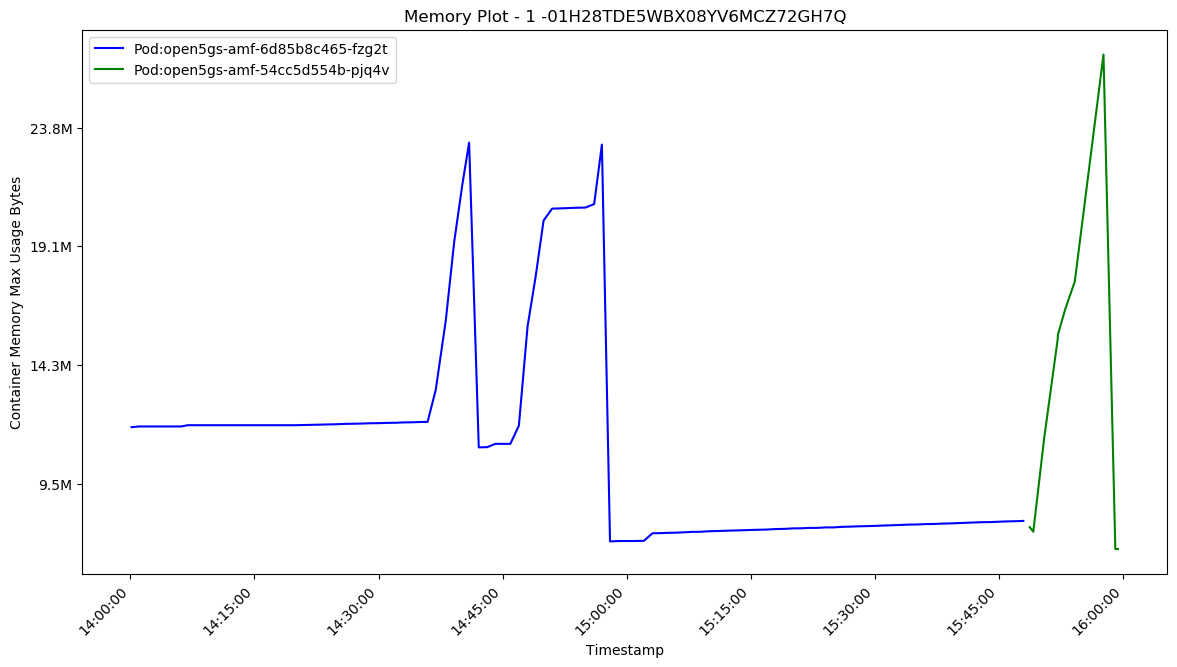

In [23]:
plot(df_pod11,df_pod12,'container_memory_max_usage_bytes_value','Container Memory Max Usage Bytes','Memory Plot - 1 -01H28TDE5WBX08YV6MCZ72GH7Q')


### container_memory_usage_bytes

In [24]:
pod21 = df_date.filter(col("metric_pod").startswith('open5gs-amf-6d85b8c465-fzg2t')).select("metric_pod",'date_col','metric___name__','values','metric_id').filter((col('metric___name__')=='container_memory_usage_bytes'))
#pod21.show(df_date.count(),truncate=False)
pod22 = df_date.filter(col("metric_pod").startswith('open5gs-amf-54cc5d554b-pjq4v')).select("metric_pod",'date_col','metric___name__','values','metric_id').filter((col('metric___name__')=='container_memory_usage_bytes'))
#pod22.show(df_date.count(),truncate=False)

In [25]:
pod21_dict = get_pod(pod21,'container_memory_usage_bytes_value')
pod22_dict = get_pod(pod22,'container_memory_usage_bytes_value')

In [31]:
df_pod21 = combine(pod21)
df_pod22 = combine(pod22)

In [32]:
# Select 3 containers related to our projects to check duplications
df_pod21 = df_pod21.filter((col("metric_id") == "/kubepods.slice/kubepods-besteffort.slice/kubepods-besteffort-pod359da734_d215_4ea7_9e05_5e7bdd7d4b07.slice/cri-containerd-ee845590e6710cfdda13f2e6ea267697a0bec794cb854894698783ad27826035.scope") | (col("metric_id") == "/kubepods.slice/kubepods-besteffort.slice/kubepods-besteffort-pod359da734_d215_4ea7_9e05_5e7bdd7d4b07.slice/cri-containerd-7f3f44350d0b3438625960f8720d8f2246f2c3be91a87fd7372afb65c9f3d4b2.scope") | (col("metric_id") == "/kubepods.slice/kubepods-besteffort.slice/kubepods-besteffort-pod359da734_d215_4ea7_9e05_5e7bdd7d4b07.slice/cri-containerd-04e301394b9cf30616b4a6182c11c40c4735f845478e869f79e667f931a266e3.scope")).select('values','date_col').withColumnRenamed("values", "container_memory_usage_bytes_value")
df_pod22 = df_pod22.filter((col("metric_id") == "/kubepods.slice/kubepods-besteffort.slice/kubepods-besteffort-pod4cc4bf41_eaba_43b4_8fd4_00a41fe807e0.slice/cri-containerd-0e519ee37b5c8f49eeef4aaf8b45276f0e84199c7c1fd120ed48030567c8d2f6.scope") | (col("metric_id") == "/kubepods.slice/kubepods-besteffort.slice/kubepods-besteffort-pod4cc4bf41_eaba_43b4_8fd4_00a41fe807e0.slice") | (col("metric_id") == "/kubepods.slice/kubepods-besteffort.slice/kubepods-besteffort-pod4cc4bf41_eaba_43b4_8fd4_00a41fe807e0.slice/cri-containerd-20d8edf3d5170067c4f37df7706f0ba5ecccdb32f2f7455584ea41263c5f955c.scope")).select('values','date_col').withColumnRenamed("values", "container_memory_usage_bytes_value")

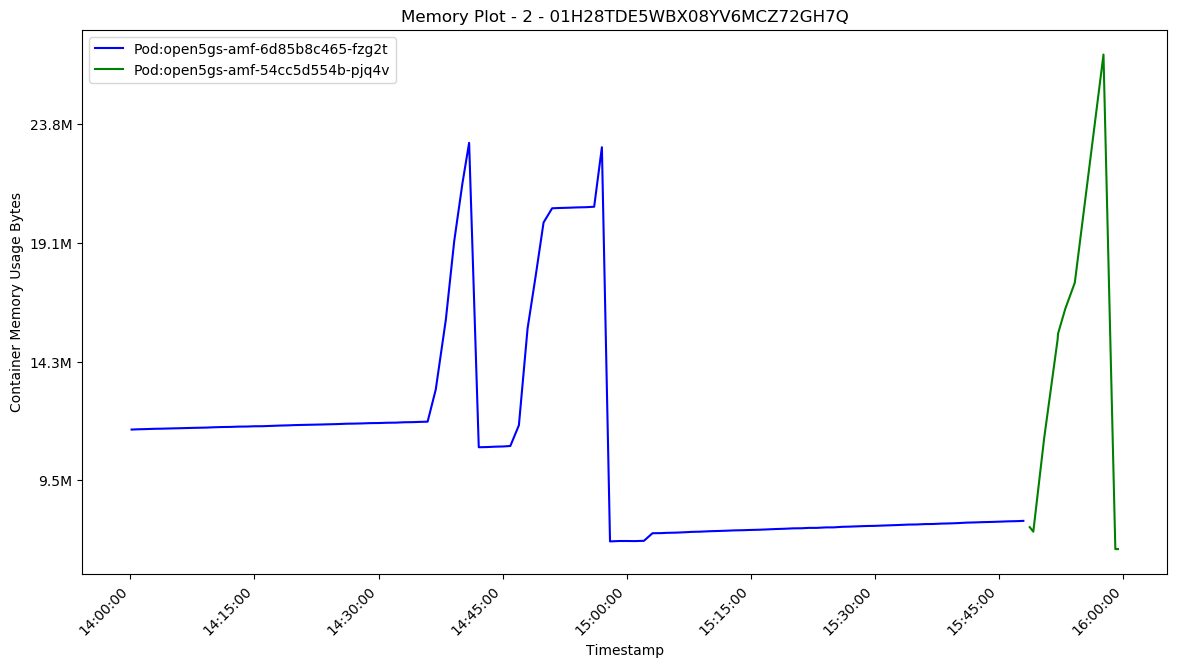

In [33]:
plot(df_pod21,df_pod22,'container_memory_usage_bytes_value','Container Memory Usage Bytes','Memory Plot - 2 - 01H28TDE5WBX08YV6MCZ72GH7Q')

### container_memory_working_set_bytes

In [34]:
pod31 = df_date.filter(col("metric_pod").startswith('open5gs-amf-6d85b8c465-fzg2t')).select("metric_pod",'date_col','metric___name__','values','metric_id').filter((col('metric___name__')=='container_memory_working_set_bytes'))
# pod31.show(df_date.count(),truncate=False)
pod32 = df_date.filter(col("metric_pod").startswith('open5gs-amf-54cc5d554b-pjq4v')).select("metric_pod",'date_col','metric___name__','values','metric_id').filter((col('metric___name__')=='container_memory_working_set_bytes'))
# pod32.show(df_date.count(),truncate=False)

In [35]:
pod31_dict = get_pod(pod31,'container_memory_working_set_bytes_value')
pod32_dict = get_pod(pod32,'container_memory_working_set_bytes_value')

In [36]:
df_pod31 = combine(pod31)
df_pod32 = combine(pod32)

In [37]:
# Select 3 containers related to our projects to check duplications
df_pod31 = df_pod31.filter((col("metric_id") == "/kubepods.slice/kubepods-besteffort.slice/kubepods-besteffort-pod359da734_d215_4ea7_9e05_5e7bdd7d4b07.slice/cri-containerd-ee845590e6710cfdda13f2e6ea267697a0bec794cb854894698783ad27826035.scope") | (col("metric_id") == "/kubepods.slice/kubepods-besteffort.slice/kubepods-besteffort-pod359da734_d215_4ea7_9e05_5e7bdd7d4b07.slice/cri-containerd-7f3f44350d0b3438625960f8720d8f2246f2c3be91a87fd7372afb65c9f3d4b2.scope") | (col("metric_id") == "/kubepods.slice/kubepods-besteffort.slice/kubepods-besteffort-pod359da734_d215_4ea7_9e05_5e7bdd7d4b07.slice/cri-containerd-04e301394b9cf30616b4a6182c11c40c4735f845478e869f79e667f931a266e3.scope")).select('values','date_col').withColumnRenamed("values", "container_memory_working_set_bytes_value") 
df_pod32 = df_pod32.filter((col("metric_id") == "/kubepods.slice/kubepods-besteffort.slice/kubepods-besteffort-pod4cc4bf41_eaba_43b4_8fd4_00a41fe807e0.slice/cri-containerd-0e519ee37b5c8f49eeef4aaf8b45276f0e84199c7c1fd120ed48030567c8d2f6.scope") | (col("metric_id") == "/kubepods.slice/kubepods-besteffort.slice/kubepods-besteffort-pod4cc4bf41_eaba_43b4_8fd4_00a41fe807e0.slice") | (col("metric_id") == "/kubepods.slice/kubepods-besteffort.slice/kubepods-besteffort-pod4cc4bf41_eaba_43b4_8fd4_00a41fe807e0.slice/cri-containerd-20d8edf3d5170067c4f37df7706f0ba5ecccdb32f2f7455584ea41263c5f955c.scope")).select('values','date_col').withColumnRenamed("values", "container_memory_working_set_bytes_value")

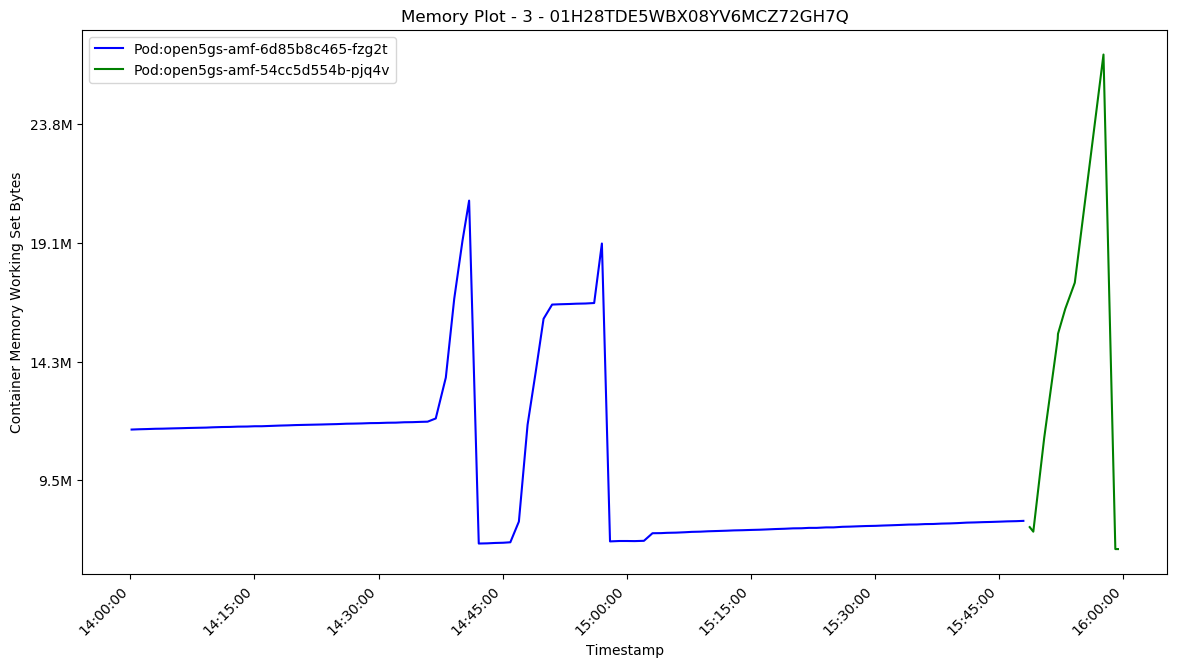

In [38]:
plot(df_pod31,df_pod32,'container_memory_working_set_bytes_value','Container Memory Working Set Bytes','Memory Plot - 3 - 01H28TDE5WBX08YV6MCZ72GH7Q')

### container_memory_cache

In [39]:
pod71 = df_date.filter(col("metric_pod").startswith('open5gs-amf-6d85b8c465-fzg2t')).select("metric_pod",'date_col','metric___name__','values','metric_id').filter((col('metric___name__')=='container_memory_cache'))
# pod31.show(df_date.count(),truncate=False)
pod72 = df_date.filter(col("metric_pod").startswith('open5gs-amf-54cc5d554b-pjq4v')).select("metric_pod",'date_col','metric___name__','values','metric_id').filter((col('metric___name__')=='container_memory_cache'))
# pod32.show(df_date.count(),truncate=False)

In [40]:
pod71_dict = get_pod(pod71,'container_memory_cache_value')
pod72_dict = get_pod(pod72,'container_memory_cache_value')

In [41]:
df_pod71 = combine(pod71)
df_pod72 = combine(pod72)

In [42]:
# Select 3 containers related to our projects to check duplications
df_pod71 = df_pod71.filter((col("metric_id") == "/kubepods.slice/kubepods-besteffort.slice/kubepods-besteffort-pod359da734_d215_4ea7_9e05_5e7bdd7d4b07.slice/cri-containerd-ee845590e6710cfdda13f2e6ea267697a0bec794cb854894698783ad27826035.scope") | (col("metric_id") == "/kubepods.slice/kubepods-besteffort.slice/kubepods-besteffort-pod359da734_d215_4ea7_9e05_5e7bdd7d4b07.slice/cri-containerd-7f3f44350d0b3438625960f8720d8f2246f2c3be91a87fd7372afb65c9f3d4b2.scope") | (col("metric_id") == "/kubepods.slice/kubepods-besteffort.slice/kubepods-besteffort-pod359da734_d215_4ea7_9e05_5e7bdd7d4b07.slice/cri-containerd-04e301394b9cf30616b4a6182c11c40c4735f845478e869f79e667f931a266e3.scope")).select('values','date_col').withColumnRenamed("values", "container_memory_cache_value") 
df_pod72 = df_pod72.filter((col("metric_id") == "/kubepods.slice/kubepods-besteffort.slice/kubepods-besteffort-pod4cc4bf41_eaba_43b4_8fd4_00a41fe807e0.slice/cri-containerd-0e519ee37b5c8f49eeef4aaf8b45276f0e84199c7c1fd120ed48030567c8d2f6.scope") | (col("metric_id") == "/kubepods.slice/kubepods-besteffort.slice/kubepods-besteffort-pod4cc4bf41_eaba_43b4_8fd4_00a41fe807e0.slice") | (col("metric_id") == "/kubepods.slice/kubepods-besteffort.slice/kubepods-besteffort-pod4cc4bf41_eaba_43b4_8fd4_00a41fe807e0.slice/cri-containerd-20d8edf3d5170067c4f37df7706f0ba5ecccdb32f2f7455584ea41263c5f955c.scope")).select('values','date_col').withColumnRenamed("values", "container_memory_cache_value") 

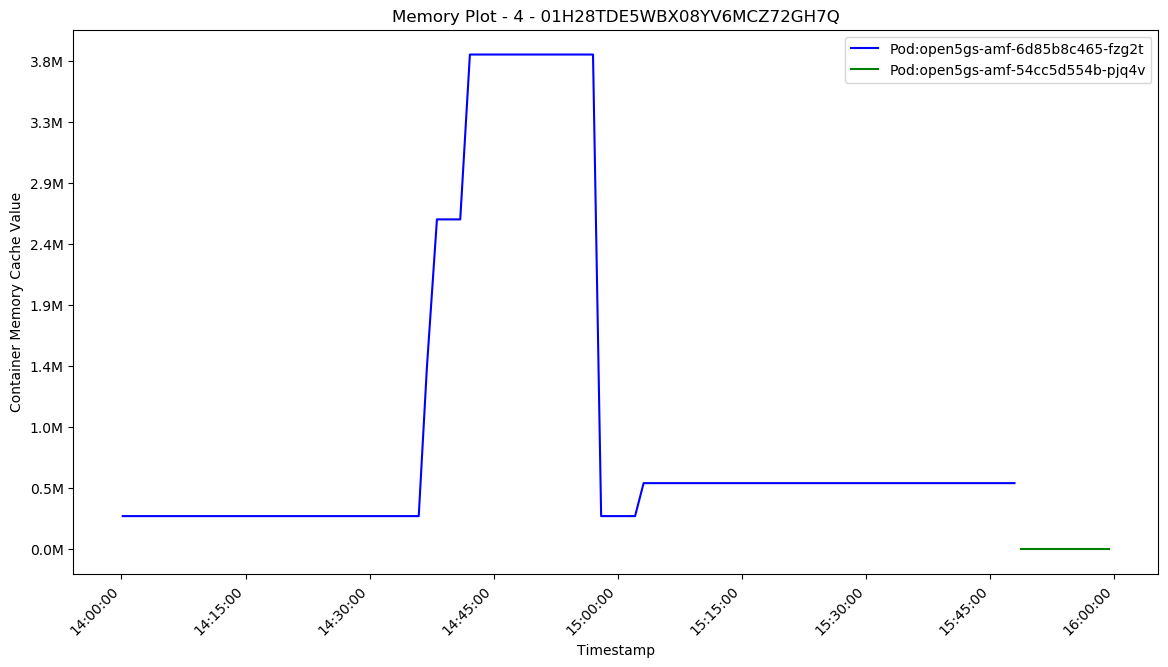

In [43]:
plot(df_pod71,df_pod72,'container_memory_cache_value','Container Memory Cache Value','Memory Plot - 4 - 01H28TDE5WBX08YV6MCZ72GH7Q')

### container_cpu_usage_seconds_total

In [44]:
pod41 = df_date.filter(col("metric_pod").startswith('open5gs-amf-6d85b8c465-fzg2t')).select("metric_pod",'date_col','metric___name__','values','metric_id').filter((col('metric___name__')=='container_cpu_usage_seconds_total'))
# pod41.show(df_date.count(),truncate=False)
pod42 = df_date.filter(col("metric_pod").startswith('open5gs-amf-54cc5d554b-pjq4v')).select("metric_pod",'date_col','metric___name__','values','metric_id').filter((col('metric___name__')=='container_cpu_usage_seconds_total'))
# pod42.show(df_date.count(),truncate=False)

In [45]:
pod41_dict = get_pod(pod41,'container_cpu_usage_seconds_total')
pod42_dict = get_pod(pod42,'container_cpu_usage_seconds_total')

In [46]:
df_pod41 = combine(pod41)
df_pod42 = combine(pod42)

In [47]:
# Select 3 containers related to our projects to check duplications
df_pod41 = df_pod41.filter((col("metric_id") == "/kubepods.slice/kubepods-besteffort.slice/kubepods-besteffort-pod359da734_d215_4ea7_9e05_5e7bdd7d4b07.slice/cri-containerd-ee845590e6710cfdda13f2e6ea267697a0bec794cb854894698783ad27826035.scope") | (col("metric_id") == "/kubepods.slice/kubepods-besteffort.slice/kubepods-besteffort-pod359da734_d215_4ea7_9e05_5e7bdd7d4b07.slice/cri-containerd-7f3f44350d0b3438625960f8720d8f2246f2c3be91a87fd7372afb65c9f3d4b2.scope") | (col("metric_id") == "/kubepods.slice/kubepods-besteffort.slice/kubepods-besteffort-pod359da734_d215_4ea7_9e05_5e7bdd7d4b07.slice/cri-containerd-04e301394b9cf30616b4a6182c11c40c4735f845478e869f79e667f931a266e3.scope")).select('values','date_col').withColumnRenamed("values", "container_cpu_usage_seconds_total") 
df_pod42 = df_pod42.filter((col("metric_id") == "/kubepods.slice/kubepods-besteffort.slice/kubepods-besteffort-pod4cc4bf41_eaba_43b4_8fd4_00a41fe807e0.slice/cri-containerd-0e519ee37b5c8f49eeef4aaf8b45276f0e84199c7c1fd120ed48030567c8d2f6.scope") | (col("metric_id") == "/kubepods.slice/kubepods-besteffort.slice/kubepods-besteffort-pod4cc4bf41_eaba_43b4_8fd4_00a41fe807e0.slice") | (col("metric_id") == "/kubepods.slice/kubepods-besteffort.slice/kubepods-besteffort-pod4cc4bf41_eaba_43b4_8fd4_00a41fe807e0.slice/cri-containerd-20d8edf3d5170067c4f37df7706f0ba5ecccdb32f2f7455584ea41263c5f955c.scope")).select('values','date_col').withColumnRenamed("values", "container_cpu_usage_seconds_total") 

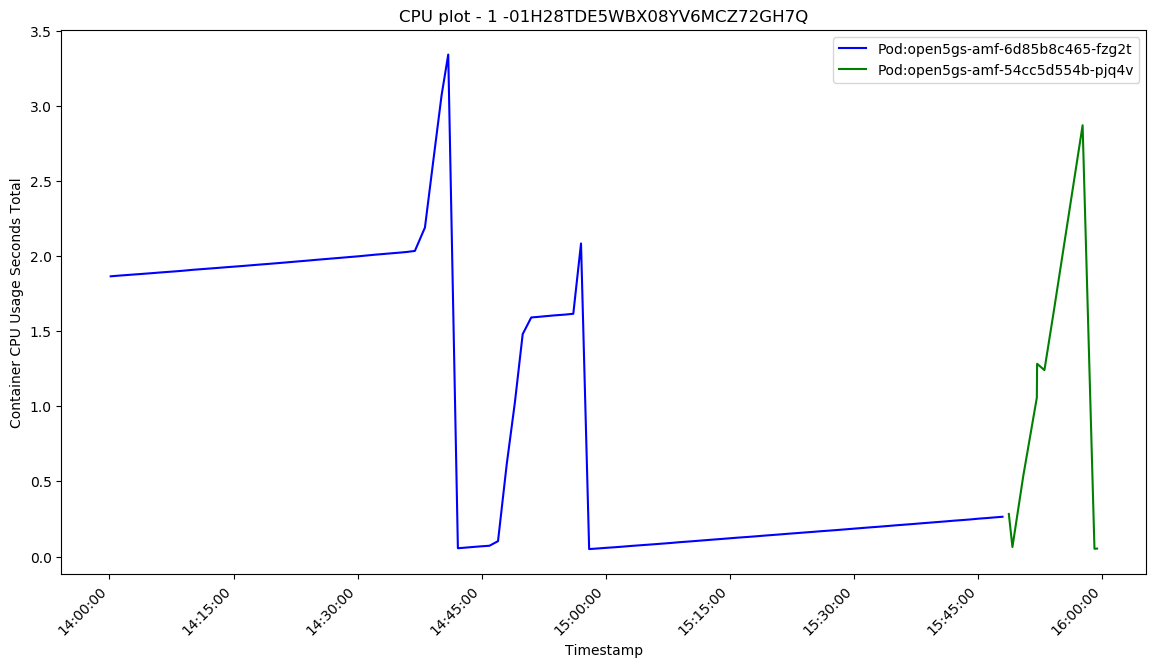

In [48]:
def plot_cpu(df1,df2, valuename, y_axis_label,n):
    
    # Create a SparkSession
    spark = SparkSession.builder.getOrCreate()
    df1 = df1.withColumnRenamed("date_col", "timestamp")
    df2 = df2.withColumnRenamed("date_col", "timestamp")
    df1_grouped = df1.groupBy("timestamp").agg(collect_list(valuename).alias("values1"))
    df2_grouped = df2.groupBy("timestamp").agg(collect_list(valuename).alias("values2"))

    # Convert timestamp column to a datetime type
    df1_grouped = df1_grouped.withColumn("timestamp", df1_grouped["timestamp"].cast("timestamp"))
    df2_grouped = df2_grouped.withColumn("timestamp", df2_grouped["timestamp"].cast("timestamp"))

    # Collect the data from the DataFrames into the driver node
    data1 = df1_grouped.collect()
    data2 = df2_grouped.collect()

    # Extract the timestamp and value columns
    timestamps1 = [row.timestamp.strftime("%Y-%m-%d %H:%M:%S") for row in data1]
    values1 = [row.values1.pop() for row in data1]
    
    timestamps2 = [row.timestamp.strftime("%Y-%m-%d %H:%M:%S") for row in data2]
    values2 = [row.values2.pop() for row in data2]
    
    # Limit the number of timestamps to plot
    num_timestamps1 = 80
    num_timestamps2 = 10
    step = max(1, len(timestamps1) // num_timestamps1)
    timestamps1 = timestamps1[::step]
    values1 = values1[::step]

    step = max(1, len(timestamps2) // num_timestamps2)
    timestamps2 = timestamps2[::step]
    values2 = values2[::step]

    # Convert timestamps to datetime objects
    timestamps1 = [datetime.strptime(ts, "%Y-%m-%d %H:%M:%S") for ts in timestamps1]
    timestamps2 = [datetime.strptime(ts, "%Y-%m-%d %H:%M:%S") for ts in timestamps2]

    # Sort timestamps in ascending order
    timestamps1, values1 = zip(*sorted(zip(timestamps1, values1)))
    timestamps2, values2 = zip(*sorted(zip(timestamps2, values2)))

    # Create a figure and axes object
    fig, ax = plt.subplots(figsize=(14, 8))

    # Plot the data
    ax.plot_date(timestamps1, values1, '-', color='blue', label='Pod:open5gs-amf-6d85b8c465-fzg2t')
    ax.plot_date(timestamps2, values2, '-', color='green', label='Pod:open5gs-amf-54cc5d554b-pjq4v')

    # Set x-axis tick format
    date_format = DateFormatter("%H:%M:%S")
    ax.xaxis.set_major_formatter(date_format)

    # Rotate x-axis labels
    fig.autofmt_xdate(rotation=45)
    
    # Add legend and labels
    ax.legend()
    ax.set_xlabel('Timestamp')
    ax.set_ylabel(y_axis_label)
    ax.set_title(n)


    # Display the plot

    plt.show()

plot_cpu(df_pod41,df_pod42,'container_cpu_usage_seconds_total','Container CPU Usage Seconds Total','CPU plot - 1 -01H28TDE5WBX08YV6MCZ72GH7Q')

### container_cpu_user_seconds_total

In [49]:
pod51 = df_date.filter(col("metric_pod").startswith('open5gs-amf-6d85b8c465-fzg2t')).select("metric_pod",'date_col','metric___name__','values','metric_id').filter((col('metric___name__')=='container_cpu_user_seconds_total'))
# pod51.show(df_date.count(),truncate=False)
pod52 = df_date.filter(col("metric_pod").startswith('open5gs-amf-54cc5d554b-pjq4v')).select("metric_pod",'date_col','metric___name__','values','metric_id').filter((col('metric___name__')=='container_cpu_user_seconds_total'))
# pod52.show(df_date.count(),truncate=False)

In [50]:
pod51_dict = get_pod(pod51,'container_cpu_user_seconds_total')
pod52_dict = get_pod(pod52,'container_cpu_user_seconds_total')

In [51]:
df_pod51 = combine(pod51)
df_pod52 = combine(pod52)

In [52]:
# Select 3 containers related to our projects to check duplications
df_pod51 = df_pod51.filter((col("metric_id") == "/kubepods.slice/kubepods-besteffort.slice/kubepods-besteffort-pod359da734_d215_4ea7_9e05_5e7bdd7d4b07.slice/cri-containerd-ee845590e6710cfdda13f2e6ea267697a0bec794cb854894698783ad27826035.scope") | (col("metric_id") == "/kubepods.slice/kubepods-besteffort.slice/kubepods-besteffort-pod359da734_d215_4ea7_9e05_5e7bdd7d4b07.slice/cri-containerd-7f3f44350d0b3438625960f8720d8f2246f2c3be91a87fd7372afb65c9f3d4b2.scope") | (col("metric_id") == "/kubepods.slice/kubepods-besteffort.slice/kubepods-besteffort-pod359da734_d215_4ea7_9e05_5e7bdd7d4b07.slice/cri-containerd-04e301394b9cf30616b4a6182c11c40c4735f845478e869f79e667f931a266e3.scope")).select('values','date_col').withColumnRenamed("values", "container_cpu_user_seconds_total") 
df_pod52 = df_pod52.filter((col("metric_id") == "/kubepods.slice/kubepods-besteffort.slice/kubepods-besteffort-pod4cc4bf41_eaba_43b4_8fd4_00a41fe807e0.slice/cri-containerd-0e519ee37b5c8f49eeef4aaf8b45276f0e84199c7c1fd120ed48030567c8d2f6.scope") | (col("metric_id") == "/kubepods.slice/kubepods-besteffort.slice/kubepods-besteffort-pod4cc4bf41_eaba_43b4_8fd4_00a41fe807e0.slice") | (col("metric_id") == "/kubepods.slice/kubepods-besteffort.slice/kubepods-besteffort-pod4cc4bf41_eaba_43b4_8fd4_00a41fe807e0.slice/cri-containerd-20d8edf3d5170067c4f37df7706f0ba5ecccdb32f2f7455584ea41263c5f955c.scope")).select('values','date_col').withColumnRenamed("values", "container_cpu_user_seconds_total") 

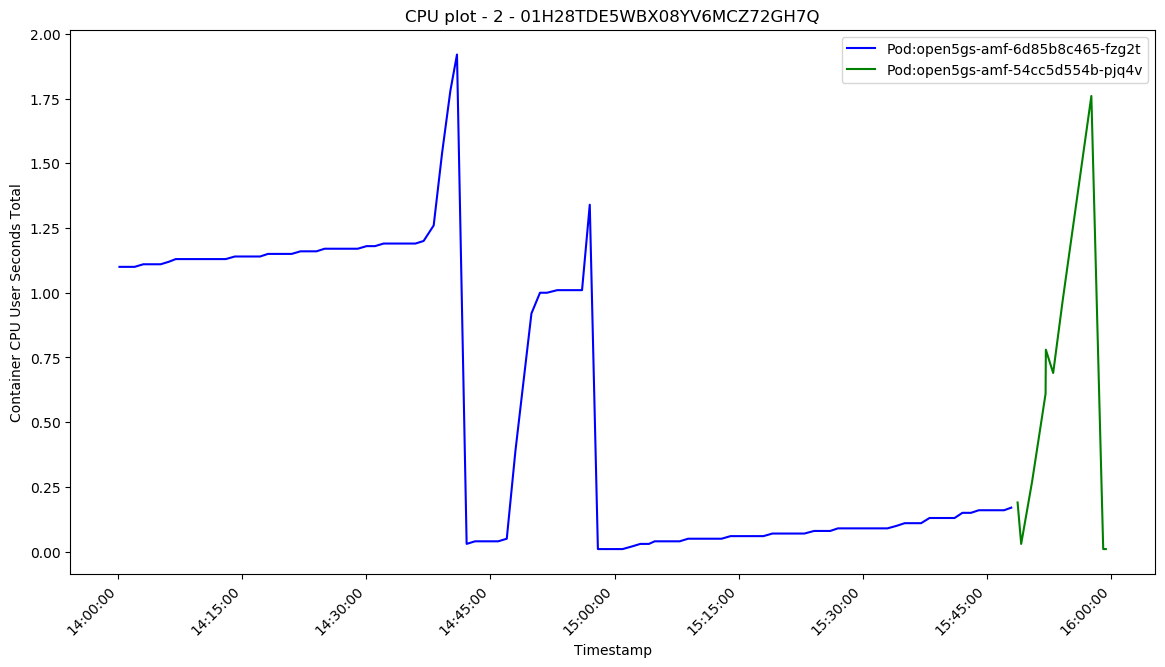

In [53]:
plot_cpu(df_pod51,df_pod52,'container_cpu_user_seconds_total','Container CPU User Seconds Total','CPU plot - 2 - 01H28TDE5WBX08YV6MCZ72GH7Q')

### container_processes

In [54]:
pod61 = df_date.filter(col("metric_pod").startswith('open5gs-amf-6d85b8c465-fzg2t')).select("metric_pod",'date_col','metric___name__','values','metric_id').filter((col('metric___name__')=='container_processes'))
# pod61.show(df_date.count(),truncate=False)
pod62 = df_date.filter(col("metric_pod").startswith('open5gs-amf-54cc5d554b-pjq4v')).select("metric_pod",'date_col','metric___name__','values','metric_id').filter((col('metric___name__')=='container_processes'))
# pod62.show(df_date.count(),truncate=False)

In [55]:
pod61_dict = get_pod(pod61,'container_processes')
pod62_dict = get_pod(pod62,'container_processes')

In [56]:
df_pod61 = combine(pod61)
df_pod62 = combine(pod62)

In [57]:
# Select 3 containers related to our projects to check duplications
df_pod61 = df_pod61.filter((col("metric_id") == "/kubepods.slice/kubepods-besteffort.slice/kubepods-besteffort-pod359da734_d215_4ea7_9e05_5e7bdd7d4b07.slice/cri-containerd-ee845590e6710cfdda13f2e6ea267697a0bec794cb854894698783ad27826035.scope") | (col("metric_id") == "/kubepods.slice/kubepods-besteffort.slice/kubepods-besteffort-pod359da734_d215_4ea7_9e05_5e7bdd7d4b07.slice/cri-containerd-7f3f44350d0b3438625960f8720d8f2246f2c3be91a87fd7372afb65c9f3d4b2.scope") | (col("metric_id") == "/kubepods.slice/kubepods-besteffort.slice/kubepods-besteffort-pod359da734_d215_4ea7_9e05_5e7bdd7d4b07.slice/cri-containerd-04e301394b9cf30616b4a6182c11c40c4735f845478e869f79e667f931a266e3.scope")).select('values','date_col').withColumnRenamed("values", "container_processes") 
df_pod62 = df_pod62.filter((col("metric_id") == "/kubepods.slice/kubepods-besteffort.slice/kubepods-besteffort-pod4cc4bf41_eaba_43b4_8fd4_00a41fe807e0.slice/cri-containerd-0e519ee37b5c8f49eeef4aaf8b45276f0e84199c7c1fd120ed48030567c8d2f6.scope") | (col("metric_id") == "/kubepods.slice/kubepods-besteffort.slice/kubepods-besteffort-pod4cc4bf41_eaba_43b4_8fd4_00a41fe807e0.slice") | (col("metric_id") == "/kubepods.slice/kubepods-besteffort.slice/kubepods-besteffort-pod4cc4bf41_eaba_43b4_8fd4_00a41fe807e0.slice/cri-containerd-20d8edf3d5170067c4f37df7706f0ba5ecccdb32f2f7455584ea41263c5f955c.scope")).select('values','date_col').withColumnRenamed("values", "container_processes") 

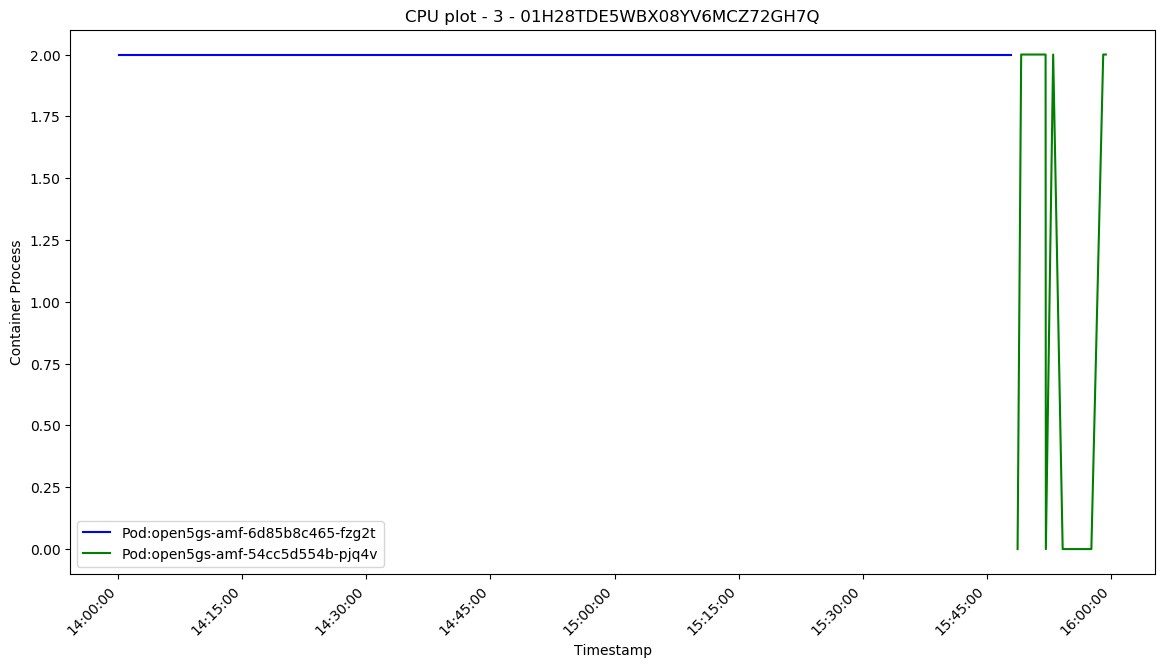

In [58]:
plot_cpu(df_pod61,df_pod62,'container_processes','Container Process','CPU plot - 3 - 01H28TDE5WBX08YV6MCZ72GH7Q')

### container_cpu_system_seconds_total

In [59]:
pod81 = df_date.filter(col("metric_pod").startswith('open5gs-amf-6d85b8c465-fzg2t')).select("metric_pod",'date_col','metric___name__','values','metric_id').filter((col('metric___name__')=='container_cpu_system_seconds_total'))
# pod81.show(df_date.count(),truncate=False)
pod82 = df_date.filter(col("metric_pod").startswith('open5gs-amf-54cc5d554b-pjq4v')).select("metric_pod",'date_col','metric___name__','values','metric_id').filter((col('metric___name__')=='container_cpu_system_seconds_total'))
# pod82.show(df_date.count(),truncate=False)

In [60]:
pod81_dict = get_pod(pod81,'container_cpu_system_seconds_total')
pod82_dict = get_pod(pod82,'container_cpu_system_seconds_total')

In [61]:
df_pod81 = combine(pod81)
df_pod82 = combine(pod82)

In [62]:
# Select 3 containers related to our projects to check duplications
df_pod81 = df_pod81.filter((col("metric_id") == "/kubepods.slice/kubepods-besteffort.slice/kubepods-besteffort-pod359da734_d215_4ea7_9e05_5e7bdd7d4b07.slice/cri-containerd-ee845590e6710cfdda13f2e6ea267697a0bec794cb854894698783ad27826035.scope") | (col("metric_id") == "/kubepods.slice/kubepods-besteffort.slice/kubepods-besteffort-pod359da734_d215_4ea7_9e05_5e7bdd7d4b07.slice/cri-containerd-7f3f44350d0b3438625960f8720d8f2246f2c3be91a87fd7372afb65c9f3d4b2.scope") | (col("metric_id") == "/kubepods.slice/kubepods-besteffort.slice/kubepods-besteffort-pod359da734_d215_4ea7_9e05_5e7bdd7d4b07.slice/cri-containerd-04e301394b9cf30616b4a6182c11c40c4735f845478e869f79e667f931a266e3.scope")).select('values','date_col').withColumnRenamed("values", "container_cpu_system_seconds_total") 
df_pod82 = df_pod82.filter((col("metric_id") == "/kubepods.slice/kubepods-besteffort.slice/kubepods-besteffort-pod4cc4bf41_eaba_43b4_8fd4_00a41fe807e0.slice/cri-containerd-0e519ee37b5c8f49eeef4aaf8b45276f0e84199c7c1fd120ed48030567c8d2f6.scope") | (col("metric_id") == "/kubepods.slice/kubepods-besteffort.slice/kubepods-besteffort-pod4cc4bf41_eaba_43b4_8fd4_00a41fe807e0.slice") | (col("metric_id") == "/kubepods.slice/kubepods-besteffort.slice/kubepods-besteffort-pod4cc4bf41_eaba_43b4_8fd4_00a41fe807e0.slice/cri-containerd-20d8edf3d5170067c4f37df7706f0ba5ecccdb32f2f7455584ea41263c5f955c.scope")).select('values','date_col').withColumnRenamed("values", "container_cpu_system_seconds_total") 

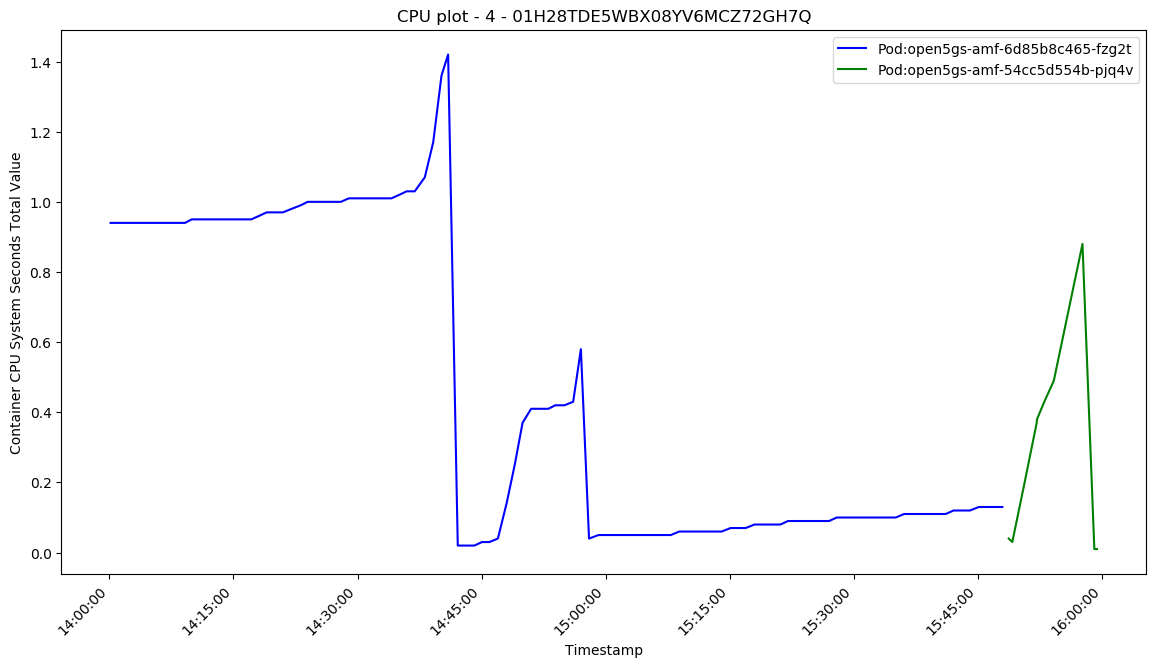

In [63]:
plot_cpu(df_pod81,df_pod82,'container_cpu_system_seconds_total','Container CPU System Seconds Total Value','CPU plot - 4 - 01H28TDE5WBX08YV6MCZ72GH7Q')

### Correlation

In [64]:
# Vertically join two DataFrames
merged_df1 = df_pod11.union(df_pod12)
merged_df2 = df_pod21.union(df_pod22)
merged_df3 = df_pod31.union(df_pod32)
merged_df4 = df_pod41.union(df_pod42)
merged_df5 = df_pod51.union(df_pod52)
merged_df6 = df_pod61.union(df_pod62)
merged_df7 = df_pod71.union(df_pod72)
merged_df8 = df_pod81.union(df_pod82)

In [65]:

dataframes = [merged_df1, merged_df2, merged_df3, merged_df7,merged_df4, merged_df5, merged_df6,merged_df8]
merged_df = merged_df1
for df in dataframes[1:]:
    merged_df = merged_df.join(df, 'date_col')
merged_df.show()

+-------------------+--------------------------------------+----------------------------------+----------------------------------------+----------------------------+---------------------------------+--------------------------------+-------------------+----------------------------------+
|           date_col|container_memory_max_usage_bytes_value|container_memory_usage_bytes_value|container_memory_working_set_bytes_value|container_memory_cache_value|container_cpu_usage_seconds_total|container_cpu_user_seconds_total|container_processes|container_cpu_system_seconds_total|
+-------------------+--------------------------------------+----------------------------------+----------------------------------------+----------------------------+---------------------------------+--------------------------------+-------------------+----------------------------------+
|2023-06-06 15:31:38|                             8232960.0|                         8101888.0|                               8101888.0|

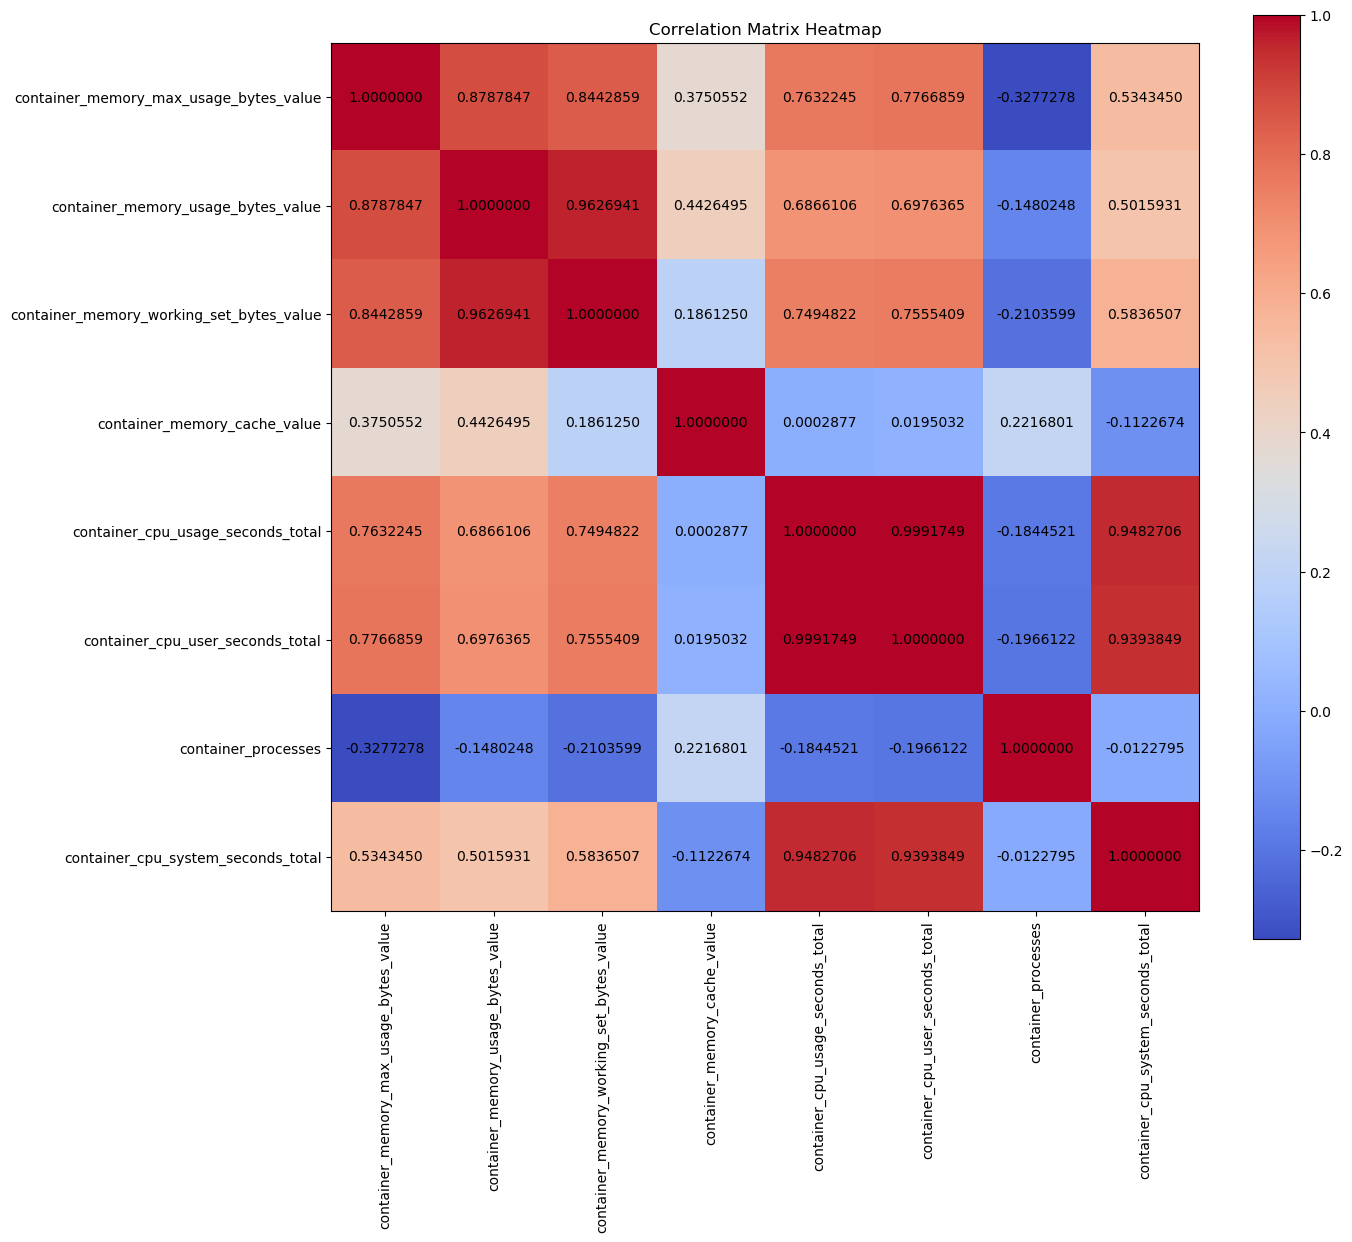

In [67]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import numpy as np
assembler = VectorAssembler(inputCols=['container_memory_max_usage_bytes_value', 'container_memory_usage_bytes_value', 'container_memory_working_set_bytes_value', 'container_memory_cache_value','container_cpu_usage_seconds_total', 'container_cpu_user_seconds_total', 'container_processes','container_cpu_system_seconds_total'],
                            outputCol="features")
features = ['container_memory_max_usage_bytes_value', 'container_memory_usage_bytes_value', 'container_memory_working_set_bytes_value','container_memory_cache_value', 'container_cpu_usage_seconds_total', 'container_cpu_user_seconds_total', 'container_processes','container_cpu_system_seconds_total']
                           
# Transform the DataFrame to include the vector column
vector_df = assembler.transform(merged_df).select("features")
# Calculate the correlation matrix
matrix = Correlation.corr(vector_df, "features").head()
# Extract the correlation matrix from the result
correlation_matrix = matrix[0].toArray()

fig, ax = plt.subplots(figsize=(14, 12))
# Create the heatmap using the correlation matrix
heatmap = ax.imshow(correlation_matrix, cmap='coolwarm')
# Add colorbar to the heatmap
cbar = plt.colorbar(heatmap)
# Set the labels for the x and y axes
ax.set_xticks(np.arange(correlation_matrix.shape[1]))
ax.set_yticks(np.arange(correlation_matrix.shape[0]))
ax.set_xticklabels(features, rotation=45)
ax.set_yticklabels(features)
# # Rotate the x-axis labels for better visibility
plt.xticks(rotation=90)
# Add correlation numbers to the heatmap
for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        ax.text(j, i, format(correlation_matrix[i, j], ".7f"), ha='center', va='center', color='black')
# Set the title and show the plot
ax.set_title("Correlation Matrix Heatmap")
plt.show()